In [58]:
## Standard imports
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import tqdm
import arviz as az

## Relative imports
from astroddpm.runners import Diffuser, config_from_id, get_samples
from astroddpm.analysis.validationMetrics import powerSpectrum
from astroddpm.utils.plot import check_nearest_epoch, plot_losses, check_training_samples, plot_comparaison
from astroddpm.diffusion.dm import DiscreteSBM
from astroddpm.diffusion.stochastic.sde import DiscreteVPSDE, ContinuousSDE, ContinuousVPSDE
from astroddpm.diffusion.stochastic.solver import get_schedule
from astroddpm.diffusion.models.network import ResUNet
import astroddpm.utils.colormap_custom ## For CMB colormap (do not remove)
from astroddpm.moment.models import MomentModel, TparamMomentNetwork

## Imports for inference
from inference.cmb_ps import CMBPS
from inference.utils import unnormalize_phi, normalize_phi, log_prior_phi, sample_prior_phi, log_likelihood_eps_phi, get_phi_bounds
from inference.hmc import HMC

## Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [59]:
## Matplotlib parameters
save_fig = False

params = {'text.usetex': True,
         'text.latex.preamble': r'\usepackage{amsmath}',
         "font.family": "serif", "font.serif": ["Computer Modern Roman"],
         'font.size': 12,
         'image.interpolation': 'none'}
plt.rcParams.update(params)
amin = - 3
amax = 3

### Loading the diffusion models and Power spectrum model

In [60]:
norm_phi_mode = 'compact'               # Normalization mode for phi among ['compact', 'inf', None]
phi_min, phi_max = get_phi_bounds()     # Bounds on phi (unnormalized)
phi_test = torch.tensor([70, 32.1e-3])  # True phi (unnormalized)
phi_test = torch.tensor([60, 22.1e-3])  # True phi (unnormalized)

In [61]:
MODEL_ID = 'ContinuousSBM_ContinuousVPSDE_I_BPROJ_bottleneck_16_firstc_6_phi_beta_cosine'
#MODEL_ID = 'DiscreteSBM_SigmaVPSDE_I_BPROJ_N_1000_bottleneck_16_firstc_6_phi_beta_cosine'
#MODEL_ID = 'DiscreteSBM_SigmaVPSDE_I_BPROJ_N_4000_bottleneck_32_firstc_10_phi'
MODEL_ID = 'ContinuousSBM_ContinuousVPSDE_I_BPROJ_bottleneck_32_firstc_10_phi_beta_cosine_betamax_0.5_betamin_0.01'

In [62]:
placeholder_dm = DiscreteSBM(DiscreteVPSDE(1000), ResUNet())
diffuser = Diffuser(placeholder_dm)
diffuser.load(config=config_from_id(MODEL_ID), also_ckpt=True, for_training=True)
ps_model = CMBPS(norm_input_phi=norm_phi_mode).to(device)

No model id found
Loading the diffuser from a config dict.
Loading the optimizer and scheduler states from the checkpoint, as well as previous training info. You should change the model id if you want to finetune the model.


### Loading the moment model

In [63]:
MOMENT_MODEL_ID = 'MomentModel_ContinuousVPSDE_I_BPROJ_beta_0_0.01_beta_T_0.5_beta_schedule_cosine'
ckpt_moment_model = torch.load(os.path.join('/mnt/home/dheurtel/ceph/02_checkpoints/', MOMENT_MODEL_ID, 'ckpt.pt'))

config_moment_model = ckpt_moment_model['config']
moment_network = TparamMomentNetwork(**config_moment_model['network']).to(device)
#moment_network = TparamMomentNetwork(in_channels=1, in_size=256, dim_param=2, order=1, num_blocks=3,
#                               first_channels=10).to(device)
#sde_moment_model = ContinuousVPSDE(beta_min=0.01, beta_max=0.5, beta_schedule='cosine') ## Careful different tmin 
config_moment_model['sde'].pop('type')
sde_moment_model = ContinuousVPSDE(**config_moment_model['sde'])
sde_moment_model.beta_0 = 0.01
sde_moment_model.beta_T = 0.5

moment_model = MomentModel(moment_network, sde_moment_model, ps = diffuser.diffmodel.ps).to(device)
## Ps will be disregarded
moment_model.load_state_dict(ckpt_moment_model['model'])

<All keys matched successfully>

### Loading the data and building our synthetic superpositions

In [64]:
## Original image

batch = next(iter(diffuser.test_dataloader))
image = batch.unsqueeze(1).to(device)[1:2]

In [65]:
## Parameters for the Gibbs sampler and noise level/timestep

NUM_CHAIN = 8
NOISE_LEVEL = 0.5
nparams = 2 
##Closest time step to the noise level requested
TIME_STEP = diffuser.diffmodel.sde.get_closest_timestep(torch.tensor(NOISE_LEVEL))
TIME_STEP = TIME_STEP.to(device)
print(f"Time step chosen for noise level {NOISE_LEVEL}: {TIME_STEP.item()}")

Time step chosen for noise level 0.5: 0.9360769391059875


In [66]:
## Target cosmological parameters (and rescaled version)

phi_test_norm = normalize_phi(phi_test, mode=norm_phi_mode).to(device)
phi_test_norm = torch.tensor([0.8,0.8]).to(device)
print("Normalized test phi:", phi_test_norm)
ps_test = ps_model(phi_test_norm)
sq_ps_test = torch.sqrt(ps_test).to(device)

## Convert to float32
sq_ps_test = sq_ps_test.to(torch.float32)
sq_ps_test.shape

Normalized test phi: tensor([0.8000, 0.8000], device='cuda:0')


torch.Size([1, 256, 256])

In [67]:
## Artificial superposition of CMB and dust map

noisy, mean, noise = diffuser.diffmodel.sde.sampling(image, TIME_STEP, sq_ps_test)
batch_mean = mean.repeat(NUM_CHAIN, 1, 1, 1)
noisy_batch = noisy.repeat(NUM_CHAIN, 1, 1, 1)

batch = image.repeat(NUM_CHAIN, 1, 1, 1) ## Changing the value of batch (we don't need the other images)
rphi_0 = sample_prior_phi(NUM_CHAIN, norm = norm_phi_mode).to(device)
phi_0 = unnormalize_phi(rphi_0, mode=norm_phi_mode).to(device)
rphi_0

tensor([[0.4517, 0.1384],
        [0.3957, 0.9447],
        [0.2427, 0.2396],
        [0.5515, 0.5851],
        [0.2487, 0.2219],
        [0.4940, 0.2908],
        [0.9899, 0.5809],
        [0.2827, 0.6656]], device='cuda:0')

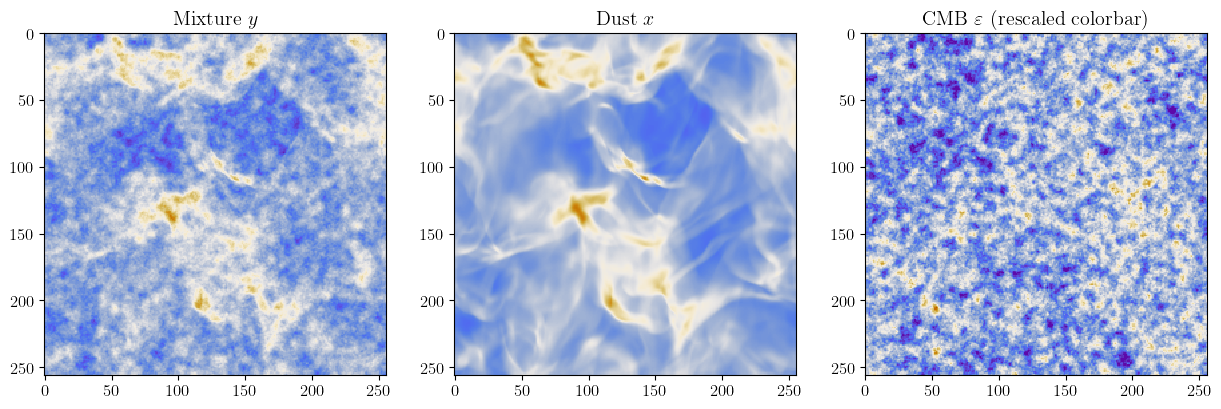

In [68]:
## Plot the noisy image (superposition) along with the noise (CMB/added gaussian components) and baseline (Dust/original image)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(noisy[0, 0].cpu().numpy(), cmap='cmb', vmin=-3, vmax=6)
ax[0].set_title('Mixture $y$')
ax[1].imshow(batch[0, 0].cpu().numpy(), cmap='cmb', vmin=-3, vmax=6)
ax[1].set_title('Dust $x$')
ax[2].imshow(noise[0, 0].cpu().numpy(), cmap='cmb', vmin=-3, vmax=6)
ax[2].set_title(r'CMB $\varepsilon$ (rescaled colorbar)')
#plt.savefig('inference_mixture_{:.2f}.pdf'.format(NOISE_LEVEL), bbox_inches='tight')
plt.show()

In [69]:
#
# Prior, likelihood, and posterior functions
#

sample_prior = lambda n: sample_prior_phi(n, norm=norm_phi_mode, device=device)
log_likelihood = lambda phi, x: log_likelihood_eps_phi(phi, x, ps_model)
log_prior = lambda phi: log_prior_phi(phi, norm=norm_phi_mode)

def log_posterior(phi, x):
    """
    Compute the log posterior of the parameters (not normalized by the evidence).
    """
    return log_likelihood(phi, x) + log_prior(phi)

## Helpers for HMC bounday management

phi_min_norm, phi_max_norm = get_phi_bounds(device=device)
phi_min_norm, phi_max_norm = normalize_phi(phi_min_norm, mode=norm_phi_mode), normalize_phi(phi_max_norm, mode=norm_phi_mode)

def collision_manager(q, p, p_nxt):
    p_ret = p_nxt

    for i in range(nparams):
        crossed_min_boundary = q[..., i] < phi_min_norm[i]
        crossed_max_boundary = q[..., i] > phi_max_norm[i]

        # Reflecting boundary conditions
        p_ret[..., i][crossed_min_boundary] = -p[..., i][crossed_min_boundary]
        p_ret[..., i][crossed_max_boundary] = -p[..., i][crossed_max_boundary]

    return p_ret

In [70]:
N_GIBBS = 20
BURNIN_HEURISTIC = 1
BURNIN_GIBBS = 0

timesteps = TIME_STEP * torch.ones(NUM_CHAIN, dtype=torch.int32).to(device)

In [71]:
phi_list = []
rphi_list = []
rescaled_batch = diffuser.diffmodel.sde.rescale_preserved_to_additive(noisy_batch, timesteps)

In [72]:
#phi = phi_0.clone().to(device)
TIME_STEP_MOMENT = sde_moment_model.get_closest_timestep(torch.tensor(NOISE_LEVEL))
timesteps_moment = TIME_STEP_MOMENT * torch.ones((NUM_CHAIN,1), dtype=torch.int32).to(device)
rphi = (moment_network(noisy_batch, timesteps_moment)+1)/2
phi = unnormalize_phi(rphi, mode=norm_phi_mode).to(device)
progress_bar = tqdm.tqdm(range(N_GIBBS+BURNIN_GIBBS+BURNIN_HEURISTIC))

phi_list.append(phi)
rphi_list.append(rphi)
for n in range(N_GIBBS+BURNIN_GIBBS+BURNIN_HEURISTIC):
	if isinstance(diffuser.diffmodel.sde, ContinuousSDE):
		schedule = get_schedule('power_law', t_min = diffuser.diffmodel.sde.tmin, t_max = TIME_STEP.item(), n_iter = 600, power = 2)
		X_0 = diffuser.diffmodel.generate_image(NUM_CHAIN, sample = noisy_batch, schedule = schedule.to(device), verbose=False, phi = phi)
	else:
		X_0 = diffuser.diffmodel.generate_image(NUM_CHAIN, sample = noisy_batch, initial_timestep=TIME_STEP, verbose=False, phi = phi)
	_, mean, _ = diffuser.diffmodel.sde.sampling(X_0, TIME_STEP)
	epsilon_hat = (rescaled_batch - mean)/diffuser.diffmodel.sde.noise_level(timesteps).reshape(-1, 1, 1, 1)
	epsilon_hat = epsilon_hat[:, 0, :, :]
	log_prob = lambda rphi: log_posterior(rphi, epsilon_hat)
	def log_prob_grad(rphi):
		""" Compute the log posterior and its gradient."""
		rphi.requires_grad_(True)
		log_prob = log_posterior(rphi, epsilon_hat)
		grad_log_prob = torch.autograd.grad(log_prob, rphi, grad_outputs=torch.ones_like(log_prob))[0]
		return log_prob.detach(), grad_log_prob

	rphi = normalize_phi(phi, mode=norm_phi_mode)
	if n < BURNIN_HEURISTIC:
		hmc = HMC(log_prob, log_prob_and_grad=log_prob_grad)
		hmc.set_collision_fn(collision_manager)

		samples = hmc.sample(rphi, nsamples=1, burnin=100, step_size=1e-6, nleap = (5,15), epsadapt=100, verbose = False, ret_side_quantities=False)
		step_size = hmc.step_size
		inv_mass_matrix = hmc.mass_matrix_inv
	else:
		hmc = HMC(log_prob, log_prob_and_grad=log_prob_grad, inv_mass_matrix=inv_mass_matrix)
		hmc.set_collision_fn(collision_manager)
		samples = hmc.sample(rphi, nsamples=1, burnin=10, step_size=step_size, nleap = (5,15), epsadapt=0, verbose = False)
	
	if (samples[:,0,:] - rphi == 0).all():
		print('HMC rejecting all')
		break
	rphi = samples[:,0,:]
	rphi_list.append(rphi)
	phi = unnormalize_phi(rphi, mode=norm_phi_mode)
	phi_list.append(phi)
	phi.detach()
	rphi.detach()
	phi.requires_grad_()
	phi = phi.to(device)
	progress_bar.update(1)
progress_bar.close()

  0%|          | 0/21 [00:00<?, ?it/s]

Adapting step size using 100 iterations
Step size fixed to :  tensor([0.0113, 0.0115, 0.0110, 0.0121, 0.0112, 0.0118, 0.0115, 0.0118],
       device='cuda:0', grad_fn=<ExpBackward0>)


 29%|██▊       | 6/21 [00:37<01:25,  5.71s/it]

In [ ]:
tensor_rphi_list = [rphi.unsqueeze(0) for rphi in rphi_list]
tensor_rphi_list = torch.cat(tensor_rphi_list, dim=0)
tensor_rphi_list.shape

torch.Size([22, 8, 2])

In [ ]:
tensor_phi_list = [phi.unsqueeze(0) for phi in phi_list]
tensor_phi_list = torch.cat(tensor_phi_list, dim=0)
tensor_phi_list.shape

torch.Size([22, 8, 2])

In [ ]:
phi_test_norm

tensor([0.8000, 0.8000], device='cuda:0')

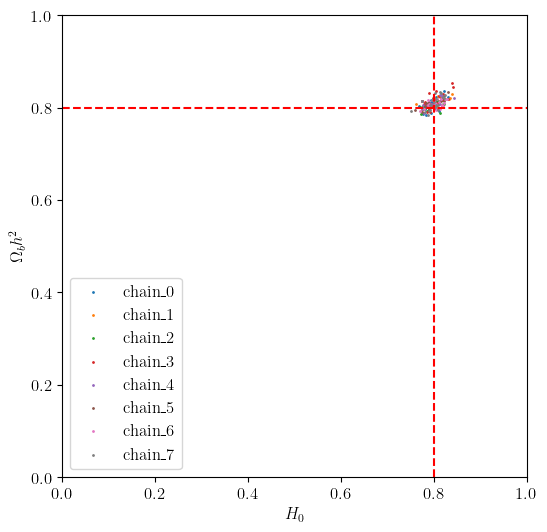

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
for i in range(tensor_rphi_list.shape[1]):
    ax.scatter(tensor_rphi_list[:, i, 0].detach().cpu().numpy(), tensor_rphi_list[:,i, 1].detach().cpu().numpy(), s=1, alpha=1, label = 'chain_{}'.format(i))
ax.axvline(phi_test_norm[0].detach().cpu().numpy(), color='red', linestyle='--')
ax.axhline(phi_test_norm[1].detach().cpu().numpy(), color='red', linestyle='--')
plt.xlabel(r"$H_0$")
plt.ylabel(r"$\Omega_b h^2$")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend()
#plt.savefig('phi.png')
plt.show()

In [712]:
stuck_chain = (tensor_rphi_list[10,:]==tensor_rphi_list[-1,:])
stuck_chain = stuck_chain.all(dim=-1)
interesting_chains = [i for i in range(NUM_CHAIN) if not stuck_chain[i]]
interesting_chains

[0, 1, 2, 3, 4, 5, 6, 7]

(0.0, 1.0)

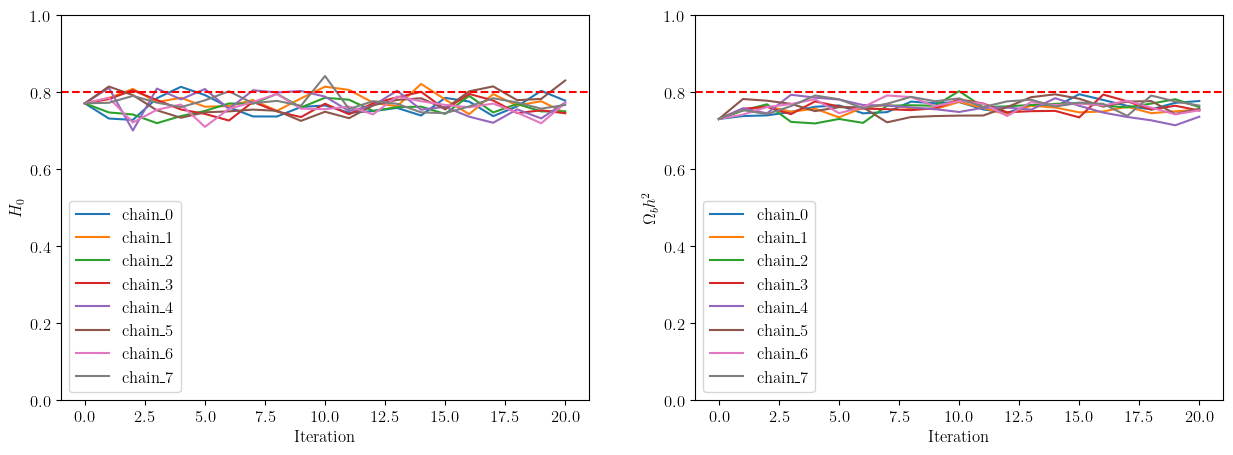

In [713]:
### Trace plots for these chains

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
for i in interesting_chains:
    ax[0].plot(tensor_rphi_list[0:, i, 0].detach().cpu().numpy(), label = 'chain_{}'.format(i))
    ax[1].plot(tensor_rphi_list[0:, i, 1].detach().cpu().numpy(), label = 'chain_{}'.format(i))
ax[0].axhline(phi_test_norm[0].detach().cpu().numpy(), color='red', linestyle='--')
ax[1].axhline(phi_test_norm[1].detach().cpu().numpy(), color='red', linestyle='--')
ax[0].set_xlabel('Iteration')
ax[1].set_xlabel('Iteration')
ax[0].set_ylabel(r"$H_0$")
ax[1].set_ylabel(r"$\Omega_b h^2$")
ax[0].legend()
ax[1].legend()
## Set limits to 0,1
ax[0].set_ylim(0, 1)
ax[1].set_ylim(0, 1)

In [714]:
az_inf_data = az.convert_to_inference_data(tensor_rphi_list.movedim(1,0)[interesting_chains,10:,:].cpu().detach().numpy())
<<<
ess, rhat = az.ess(az_inf_data), az.rhat(az_inf_data)
print(ess['x'].values, rhat['x'].values)

SyntaxError: invalid syntax (3888752711.py, line 2)

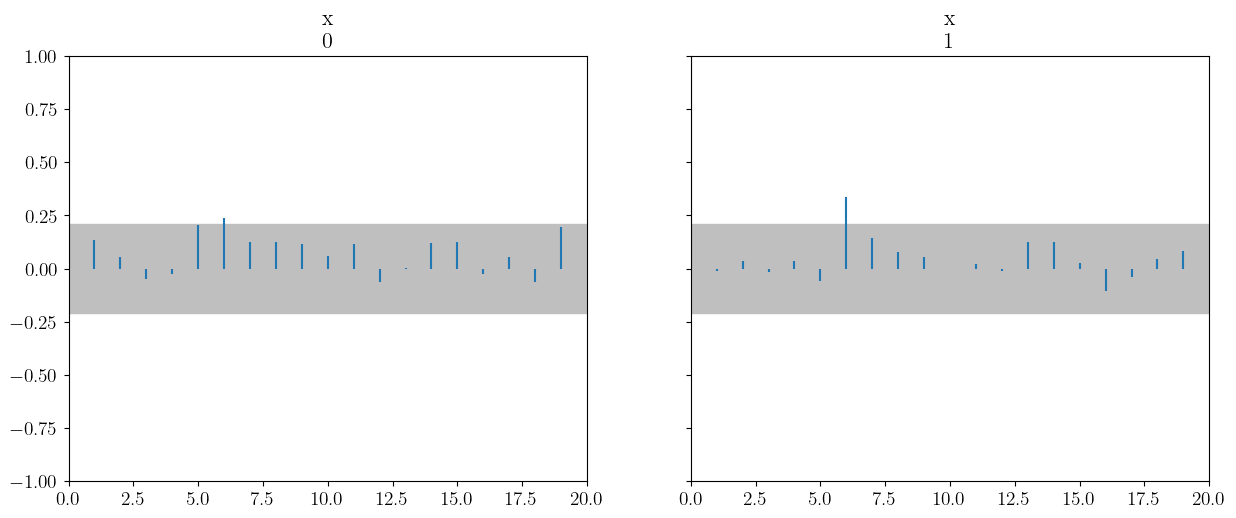

In [ ]:
im = az.plot_autocorr(az_inf_data, var_names=['x'], combined = True, max_lag=20)

Text(52, 0.01, '$\\mathrm E\\mathrm S\\mathrm S = 76.47$')

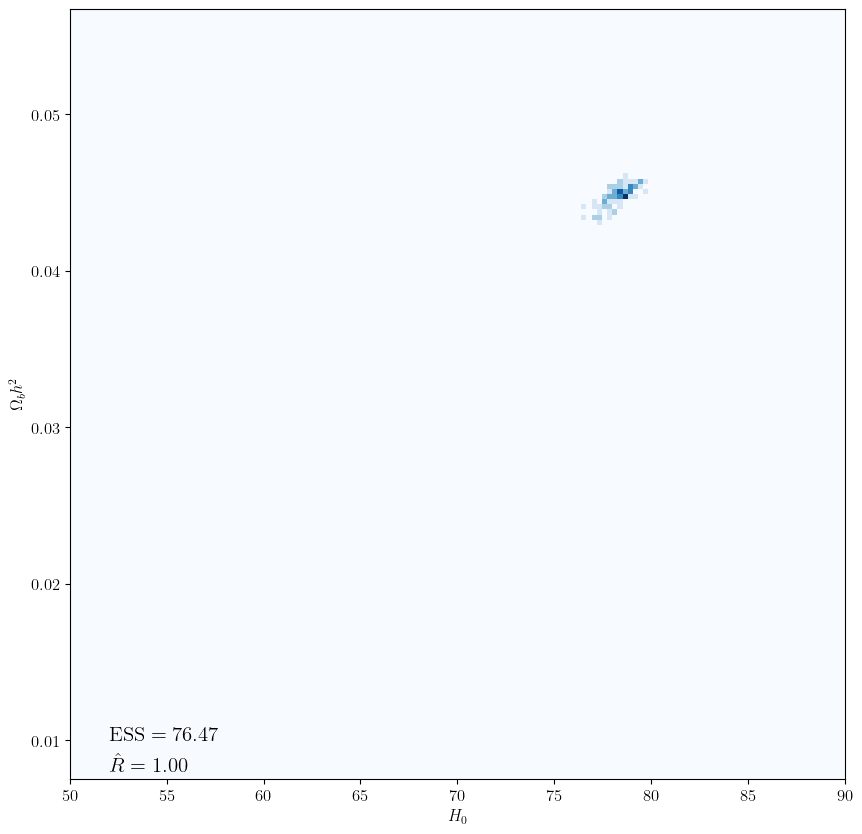

In [ ]:
### Method 1 to plot the empirical posterior of the chains using np.hist2d and plt

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

H0 = tensor_phi_list[10:, interesting_chains, 0].detach().cpu().numpy().flatten()
Obh2 = tensor_phi_list[10:, interesting_chains, 1].detach().cpu().numpy().flatten()
H0_test = phi_test_norm[0].detach().cpu().numpy()
Obh2_test = phi_test_norm[1].detach().cpu().numpy()

## plot the histogram, extent [0,1] x [0,1]
## plot the true value as a red dot

out = ax.hist2d(H0, Obh2, bins=150, range=[[50, 90], [7.5e-3, 56.7e-3]], cmap='Blues')
#ax.scatter(H0, Obh2, s=1, alpha=0.01)
ax.axvline(H0_test, color='red', linestyle='--')
ax.axhline(Obh2_test, color='red', linestyle='--')

ax.set_xlabel(r"$H_0$")
ax.set_ylabel(r"$\Omega_b h^2$")

## Add a rectangle with ess and rhat

ax.text(52, 8e-3, r'$\hat R = {:.2f}$'.format(min(rhat['x'].values)), fontsize=15)
ax.text(52, 1e-2, r'$\mathrm E\mathrm S\mathrm S = {:.2f}$'.format(min(ess['x'].values)), fontsize=15)

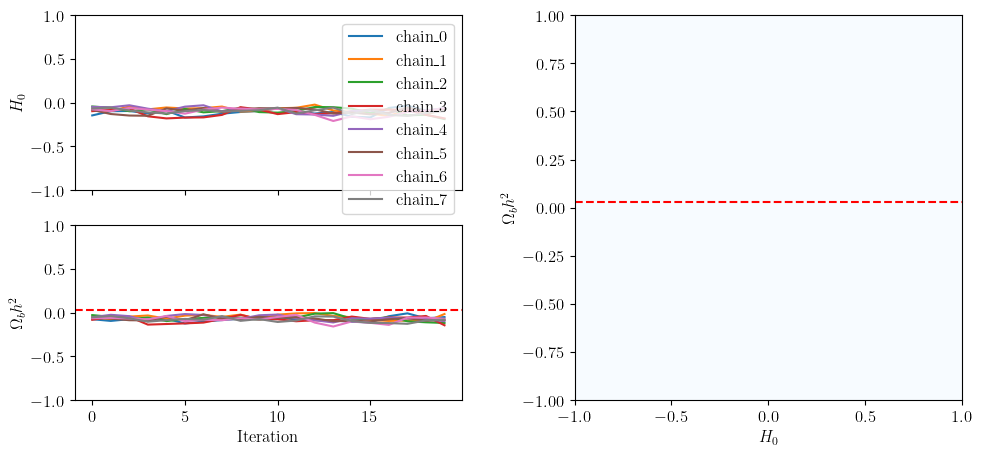

In [ ]:
## Plot side by side the traceplots and the histogram

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

subfigs = fig.subfigures(1, 2, wspace=0.1)
ax_left = subfigs[0].subplots(2, 1, sharex=True)

for i in interesting_chains:
    ax_left[0].plot(tensor_rphi_list[10:, i, 0].detach().cpu().numpy(), label = 'chain_{}'.format(i))
    ax_left[1].plot(tensor_rphi_list[10:, i, 1].detach().cpu().numpy(), label = 'chain_{}'.format(i))
ax_left[0].axhline(phi_true[0,0].detach().cpu().numpy(), color='red', linestyle='--')
ax_left[1].axhline(phi_true[0,1].detach().cpu().numpy(), color='red', linestyle='--')
ax_left[1].set_xlabel('Iteration')
ax_left[0].set_ylabel(r"$H_0$")
ax_left[1].set_ylabel(r"$\Omega_b h^2$")
ax_left[0].legend()
## Set limits to 0,1
ax_left[0].set_ylim(-1, 1)
ax_left[1].set_ylim(-1, 1)

ax_right = subfigs[1].subplots(1, 1)
ax_right.hist2d(H0, Obh2, bins=150, range=[[-1, 1], [-1, 1]], cmap='Blues')
ax_right.axvline(H0_test, color='red', linestyle='--')
ax_right.axhline(Obh2_test, color='red', linestyle='--')
ax_right.set_xlabel(r"$H_0$")
ax_right.set_ylabel(r"$\Omega_b h^2$")
#plt.savefig('inference_MCMC_{:.2f}.pdf'.format(NOISE_LEVEL), bbox_inches='tight')
plt.show()

In [ ]:
noisy_image_additive = diffuser.diffmodel.sde.rescale_preserved_to_additive(noisy_batch, timesteps)
estimated_noise = noisy_image_additive - X_0
added_noise_additive = noisy_image_additive - image

In [ ]:
##
## COMPUTTATION OF THE POWER SPECTRUM
##
## Compute power spectrum
bins = torch.linspace(0, np.pi, 100).to(device)

bins_centers = (bins[:-1] + bins[1:])/2
bins_centers = bins_centers.cpu()
mean_list = []
std_list = []
for data in [image, noisy_image_additive, added_noise_additive, X_0, estimated_noise]:
    mean_, std_ , bins = powerSpectrum.set_power_spectrum_iso2d(data.to(device), bins, use_gpu=True)
    mean_list.append(mean_)
    std_list.append(std_)

## Compute the power spectrum of the posterior mean over phi

interesting_chains = [2,4]
interesting_chains = [0,1,3,5,6]
H0_mean = tensor_rphi_list[10:, interesting_chains, 0].mean()
Obh2_mean = tensor_rphi_list[10:, interesting_chains, 1].mean()

phi_mean = torch.tensor([H0_mean, Obh2_mean]).reshape(1,2).to(device)

ps_mean = ps_model_1(phi_mean).unsqueeze(1) * NOISE_LEVEL**2 * 256**2

mean_list.append(powerSpectrum._spectral_iso2d(ps_mean, bins, use_gpu=True)[1].reshape(-1))
std_list.append(torch.zeros_like(mean_list[-1]))

## Compute the power spectrum of phi_true

ps_true = ps_model_1(phi_test_norm).unsqueeze(1) * NOISE_LEVEL**2 * 256**2

mean_list.append(powerSpectrum._spectral_iso2d(ps_true, bins, use_gpu=True)[1].reshape(-1))
std_list.append(torch.zeros_like(mean_list[-1]))

mean_list = [mean.cpu().numpy() for mean in mean_list]
std_list = [std.cpu().numpy() for std in std_list]

In [ ]:
ps_bins = bins_centers.cpu()
ps_mean_list = [mean[:-1] for mean in mean_list]
ps_std_list = [std[:-1] for std in std_list]

In [ ]:
ps_orig = ps_mean_list[0]
ps_orig_std = ps_std_list[0]
ps_noisy = ps_mean_list[1]
ps_noisy_std = ps_std_list[1]
ps_noise = ps_mean_list[2]
ps_noise_std = ps_std_list[2]
ps_denoised = ps_mean_list[3]
ps_denoised_std = ps_std_list[3]
ps_estimated_noise = ps_mean_list[4]
ps_estimated_noise_std = ps_std_list[4]
ps_posterior_mean = ps_mean_list[5]
ps_posterior_mean_std = ps_std_list[5]
ps_true = ps_mean_list[6]
ps_true_std = ps_std_list[6]

In [ ]:
ps_list = [ps_noisy, ps_orig, ps_denoised, ps_noise, ps_estimated_noise, ps_posterior_mean, ps_true]
ps_std_list = [ps_noisy_std, ps_orig_std, ps_denoised_std, ps_noise_std, ps_estimated_noise_std, ps_posterior_mean_std, ps_true_std]
ps_colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']
ps_labels = [r'Mixture $\mathbf{y}$',
             r'True Dust $\mathbf{x}$',
             r'Reconstructed Dust $\hat{\mathbf{x}}$',
             r'True CMB $\mathbf{\varepsilon}$',
             r'Reconstructed CMB $\hat{\mathbf{\varepsilon}}$',
             r'Posterior Mean cosmology', 
             r'True cosmology']

Text(0.5, 1.0, 'Power spectrum')

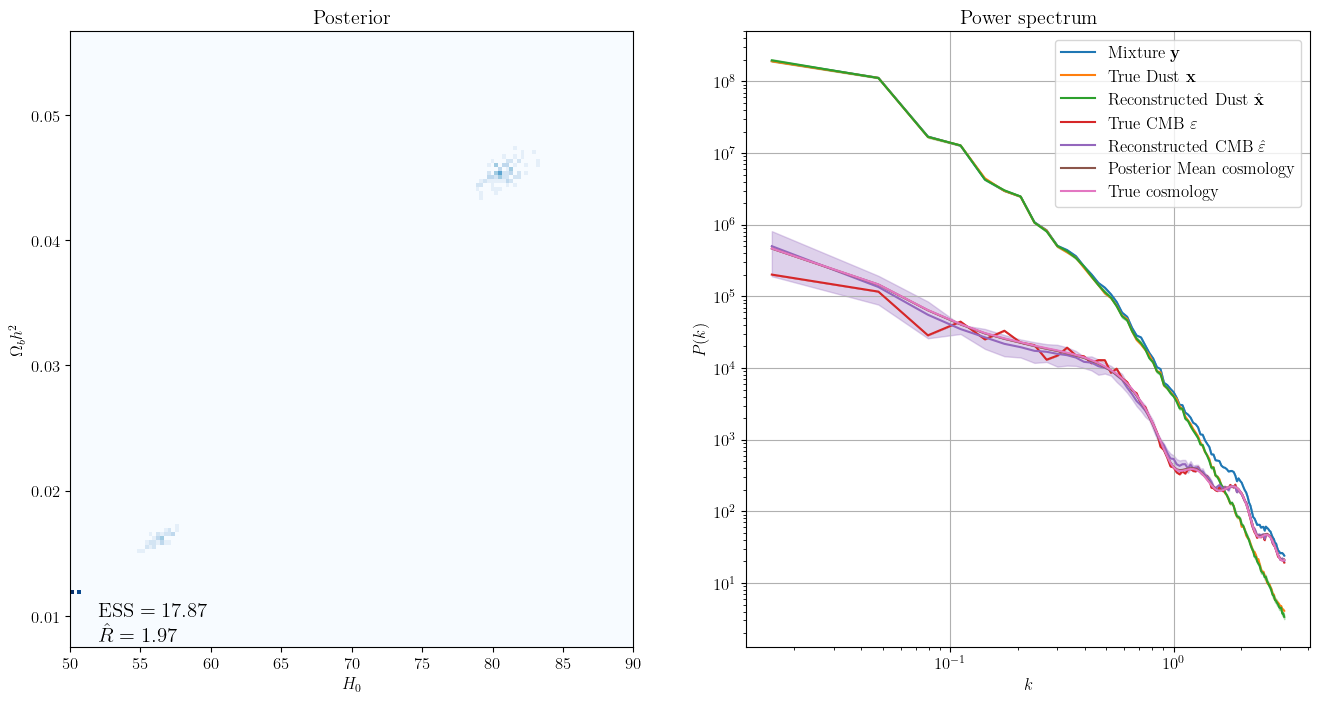

In [ ]:
## Plot side by side the histogram and the power spectrum, showing how dificult our task is

fig, ax = plt.subplots(1, 2, figsize=(16, 8))

ax[0].hist2d(H0, Obh2, bins=150, range=[[50,90], [7.5e-3, 56.7e-3]], cmap='Blues')
ax[0].axvline(H0_test, color='red', linestyle='--')
ax[0].axhline(Obh2_test, color='red', linestyle='--')
ax[0].set_xlabel(r"$H_0$")
ax[0].set_ylabel(r"$\Omega_b h^2$")
## Add ESS and Rhat as text
ax[0].text(52, 8e-3, r'$\hat R = {:.2f}$'.format(min(rhat['x'].values)), fontsize=15)
ax[0].text(52, 10e-3, r'$\mathrm E\mathrm S\mathrm S = {:.2f}$'.format(min(ess['x'].values)), fontsize=15)

ax[0].set_title('Posterior')

for ps, ps_std, color, label in zip(ps_list, ps_std_list, ps_colors, ps_labels):
    ax[1].plot(ps_bins, ps, color=color, label=label)
    ax[1].fill_between(ps_bins, ps-ps_std, ps+ps_std, color=color, alpha=0.3)

ax[1].legend()

ax[1].set_yscale('log')
ax[1].set_xscale('log')
ax[1].set_xlabel(r'$k$')
ax[1].set_ylabel(r'$P(k)$')
## Add a grid to the power spectrum plot
ax[1].grid(True)

ax[1].set_title('Power spectrum')

#plt.savefig('./images_inference/inference_MCMC_center_noise_{:.2f}_power_spectrum.pdf'.format(NOISE_LEVEL), bbox_inches='tight')


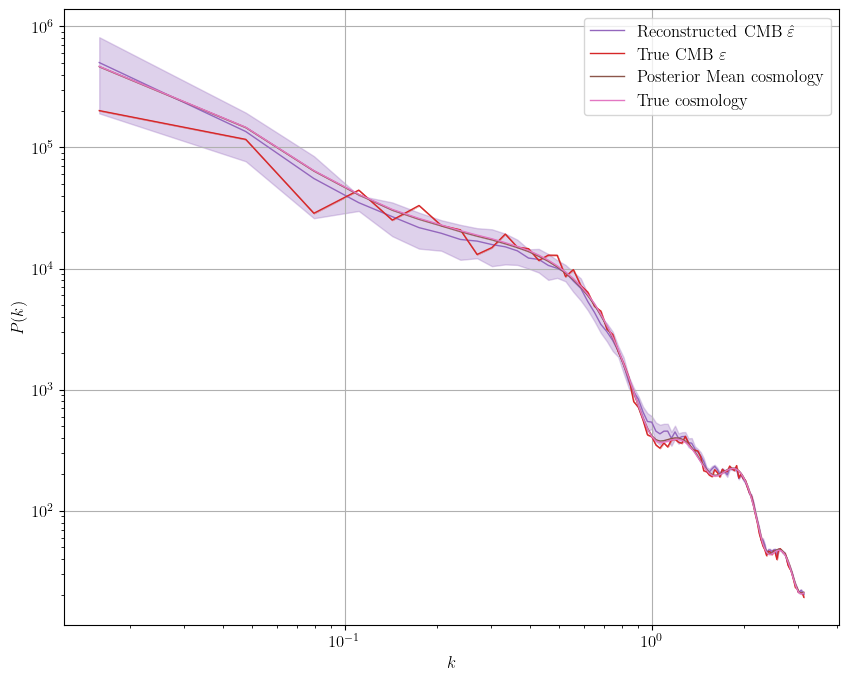

In [ ]:
## Plot only the power spectrum of estimated CMB, true CMB (ps noise), posterior mean cosmology and true cosmology

fig, ax = plt.subplots(1, 1, figsize=(10, 8))

for ps, ps_std, color, label in zip([ps_estimated_noise, ps_noise, ps_posterior_mean, ps_true], [ps_estimated_noise_std, ps_noise_std, ps_posterior_mean_std, ps_true_std], ['C4', 'C3', 'C5', 'C6'], [r'Reconstructed CMB $\hat{\mathbf{\varepsilon}}$', r'True CMB $\mathbf{\varepsilon}$', r'Posterior Mean cosmology', r'True cosmology']):
    ax.plot(ps_bins, ps, color=color, label=label, linewidth=1)
    ax.fill_between(ps_bins, ps-ps_std, ps+ps_std, color=color, alpha=0.3)

ax.legend()

ax.set_yscale('log')
ax.set_xscale('log')

ax.set_xlabel(r'$k$')
ax.set_ylabel(r'$P(k)$')

ax.grid(True)

plt.savefig('./images_inference/inference_MCMC_center_noise_{:.2f}_power_spectrum_zoom_onlyCMB.pdf'.format(NOISE_LEVEL), bbox_inches='tight')

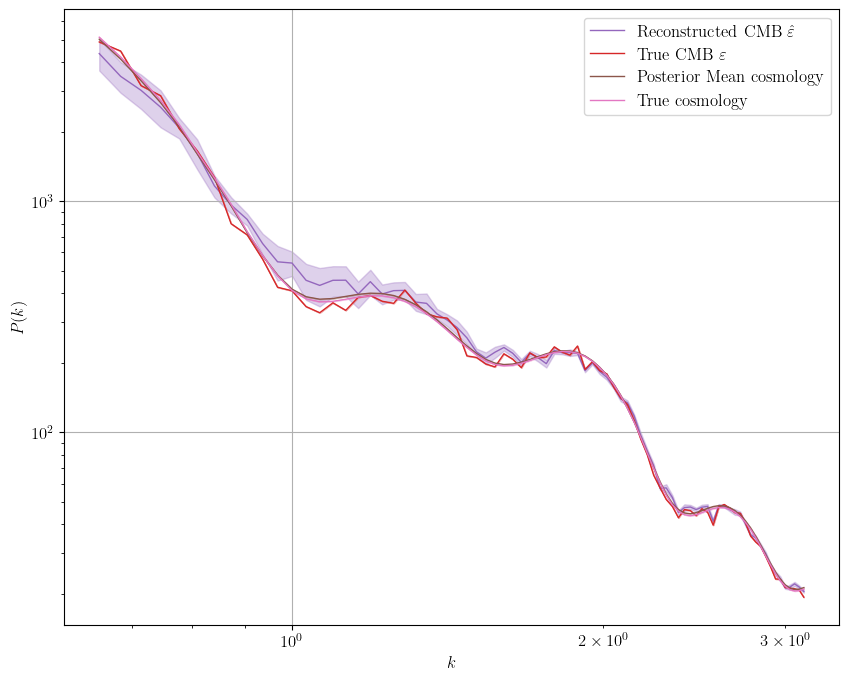

In [ ]:
## Same plot but zoomed on the small scales (discard the first 20 bins)

fig, ax = plt.subplots(1, 1, figsize=(10, 8))

for ps, ps_std, color, label in zip([ps_estimated_noise, ps_noise, ps_posterior_mean, ps_true], [ps_estimated_noise_std, ps_noise_std, ps_posterior_mean_std, ps_true_std], ['C4', 'C3', 'C5', 'C6'], [r'Reconstructed CMB $\hat{\mathbf{\varepsilon}}$', r'True CMB $\mathbf{\varepsilon}$', r'Posterior Mean cosmology', r'True cosmology']):
    ax.plot(ps_bins[20:], ps[20:], color=color, label=label, linewidth=1)
    ax.fill_between(ps_bins[20:], ps[20:]-ps_std[20:], ps[20:]+ps_std[20:], color=color, alpha=0.3)

ax.legend()

ax.set_yscale('log')
ax.set_xscale('log')

ax.set_xlabel(r'$k$')
ax.set_ylabel(r'$P(k)$')

ax.grid(True)

plt.savefig('./images_inference/inference_MCMC_center_noise_{:.2f}_power_spectrum_zoom_onlyCMB_small_scales.pdf'.format(NOISE_LEVEL), bbox_inches='tight')

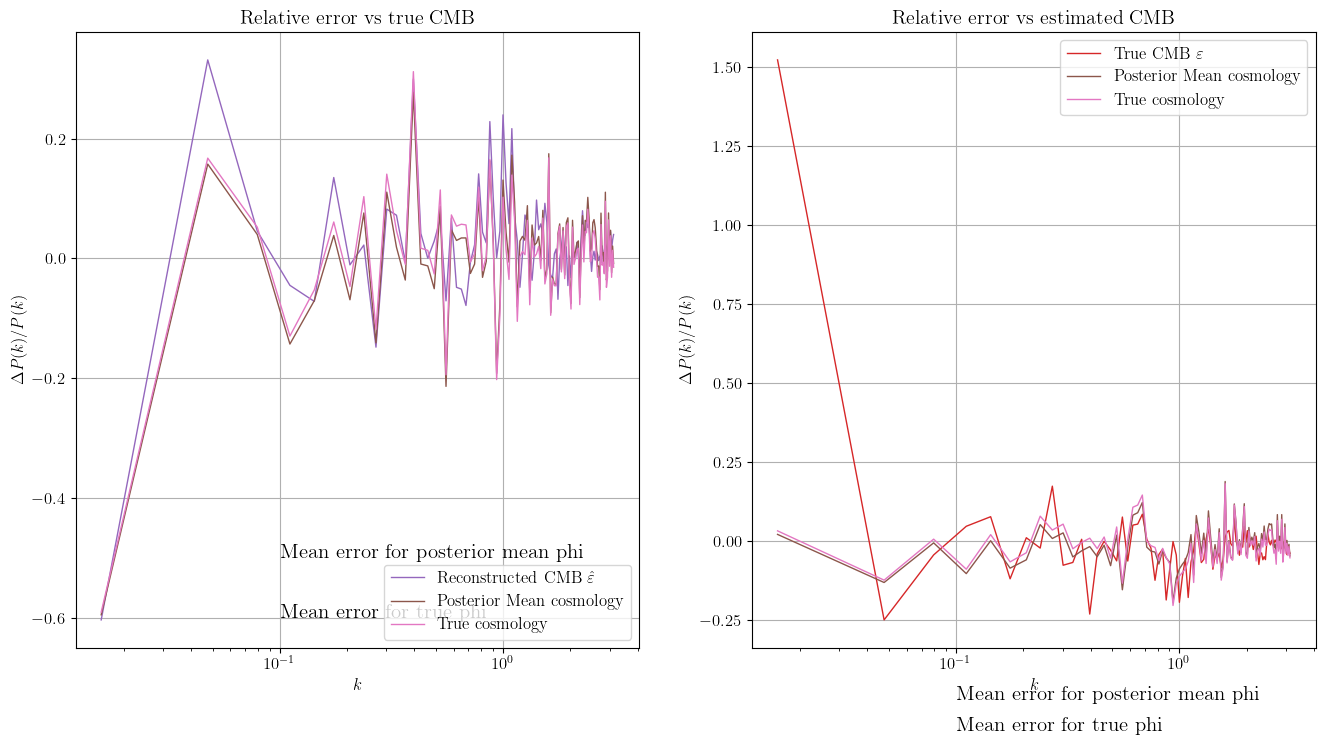

In [ ]:
## Now only plot the relative errors of estimated CMB vs true CMB (ps noise)// posterior mean cosmology vs estimated CMB // posterior mean cosmology vs true CMB // true cosmology vs estimated CMB // true cosmology vs posterior mean cosmology
## There will be two subfigs, one for relative error of any field vs true CMB (ps noise), one for relative error of any field vs estimated CMB (estimated noise)

fig, ax = plt.subplots(1, 2, figsize=(16, 8))

## Relative error of any field vs true CMB (ps noise)

for ps, ps_std, color, label in zip([ps_estimated_noise, ps_posterior_mean, ps_true], [ps_estimated_noise_std, ps_posterior_mean_std, ps_true_std], ['C4', 'C5', 'C6'], [r'Reconstructed CMB $\hat{\mathbf{\varepsilon}}$', r'Posterior Mean cosmology', r'True cosmology']):
    ax[0].plot(ps_bins, (ps-ps_noise)/ps_noise, color=color, label=label, linewidth=1)

ax[0].text(1e-1, -0.5, 'Mean error for posterior mean phi'.format(np.mean(np.abs((ps_posterior_mean - ps_noise)/ps_noise))), fontsize=15)
ax[0].text(1e-1, -0.6, 'Mean error for true phi'.format(np.mean(np.abs((ps_true - ps_noise)/ps_noise))), fontsize=15)
ax[0].legend()

ax[0].set_xscale('log')

ax[0].set_xlabel(r'$k$')
ax[0].set_ylabel(r'$\Delta P(k)/P(k)$')

ax[0].grid(True)
ax[0].set_title('Relative error vs true CMB')
## Relative error of any field vs estimated CMB (estimated noise)

for ps, ps_std, color, label in zip([ps_noise, ps_posterior_mean, ps_true], [ps_noise_std, ps_posterior_mean_std, ps_true_std], ['C3', 'C5', 'C6'], [r'True CMB $\mathbf{\varepsilon}$', r'Posterior Mean cosmology', r'True cosmology']):
    ax[1].plot(ps_bins, (ps - ps_estimated_noise)/ps_estimated_noise, color=color, label=label, linewidth=1)

## Adds the relative mean error with absolute value as text

ax[1].text(1e-1, -0.5, 'Mean error for posterior mean phi'.format(np.mean(np.abs((ps_posterior_mean - ps_estimated_noise)/ps_estimated_noise))), fontsize=15)
ax[1].text(1e-1, -0.6, 'Mean error for true phi'.format(np.mean(np.abs((ps_true - ps_estimated_noise)/ps_estimated_noise))), fontsize=15)
ax[1].legend()

ax[1].set_xscale('log')

ax[1].set_xlabel(r'$k$')
ax[1].set_ylabel(r'$\Delta P(k)/P(k)$')

ax[1].grid(True)
ax[1].set_title('Relative error vs estimated CMB')

plt.savefig('./images_inference/inference_MCMC_center_noise_{:.2f}_relative_error_power_spectrum.pdf'.format(NOISE_LEVEL), bbox_inches='tight')


In [ ]:
## Compute the log_posterior for phi given epsilon_hat[0] on a grid of value for rphi

rphi_0_grid = torch.linspace(0, 1, 180)
rphi_1_grid = torch.linspace(0, 1, 180)

rphi_0_grid, rphi_1_grid = torch.meshgrid(rphi_0_grid, rphi_1_grid)

rphi_grid = torch.stack([rphi_0_grid, rphi_1_grid], dim=-1).reshape(-1, 2).to(device)

/mnt/home/dheurtel/venv/genv_DL/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [ ]:
epsilon_hat[0].shape

torch.Size([256, 256])

In [ ]:
## Compute the log posterior on the grid, and reshape it to the shape of the grid

with torch.no_grad():
    log_posterior_grid = log_posterior(rphi_grid, epsilon_hat[0].reshape(1, 1, 256, 256)).reshape(180, 180)

In [ ]:
log_posterior_grid.shape

torch.Size([180, 180])

In [ ]:
tensor_rphi_list.shape

torch.Size([21, 8, 2])

In [ ]:
rphi_0.shape

torch.Size([8, 2])

In [ ]:
all_chain = torch.concatenate([rphi_0.unsqueeze(0), tensor_rphi_list], dim=0)

In [ ]:
all_chain.shape

torch.Size([22, 8, 2])

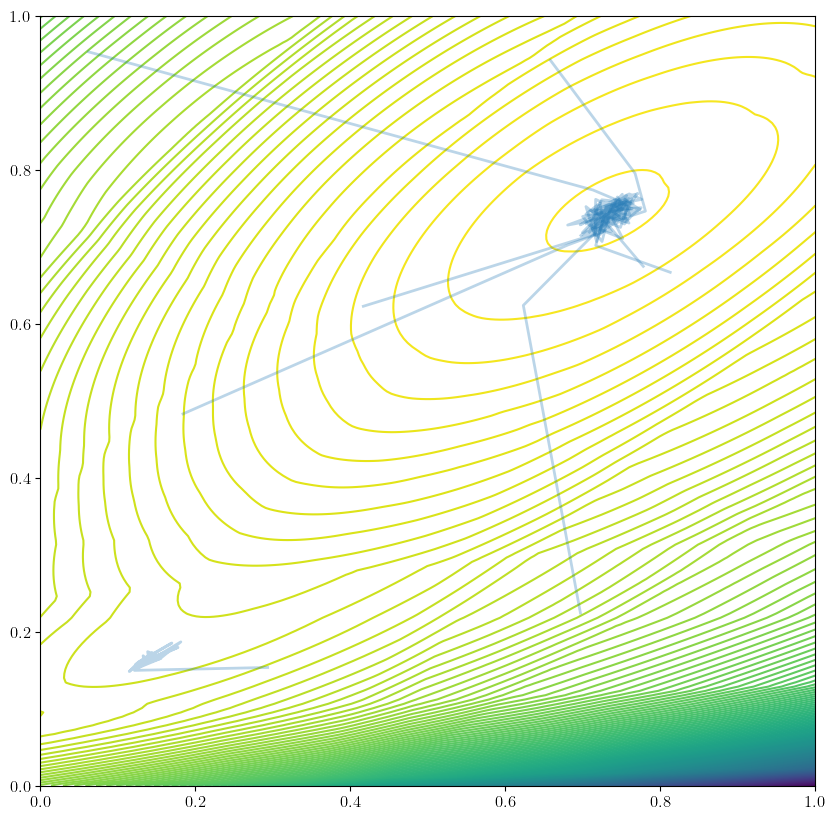

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.contour(rphi_0_grid.cpu().numpy(), rphi_1_grid.cpu().numpy(), log_posterior_grid.cpu().numpy(), levels=180)

for i in range(NUM_CHAIN):
    ax.plot(all_chain[:, i, 0].detach().cpu(), all_chain[:, i, 1].detach().cpu(), color='C0', alpha=0.3, linewidth=2)